In [ ]:
USING_COLAB = True
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ModuleNotFoundError:
    USING_COLAB = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys

if USING_COLAB is True:
    radar_path = "/content/drive/MyDrive/Radar"
else:
    radar_path = "Radar"
if radar_path not in sys.path:
    sys.path.insert(0, radar_path)

In [ ]:
import torch.nn as nn
import torch

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
!pip install wandb
!pip install mlxtend

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

def confuse(l, p, num_classes):
    cm = confusion_matrix(l, p)
    classesrep = cm.shape[0]
    if classesrep < num_classes:
        pad = num_classes - classesrep
        cm = np.pad(cm, ((0, pad), (0, pad)), mode='constant', constant_values=(0,0))  # zero pad

    assert cm.shape == (num_classes, num_classes)  # TODO why sometimes fails
    return cm

def to_one_hot_vector(num_class, label):
    b = np.zeros((label.shape[0], num_class))
    b[np.arange(label.shape[0]), label] = 1

    return b


In [ ]:
class ClassicalRadarClassifier(nn.Module):
  def __init__(self, conf):
        super(ClassicalRadarClassifier, self).__init__()
        self._conf = conf.copy()
        # i/p shape - (batch_size, Channel_in, Height_in, Width_in) - (2, 16, 251)
        self.conv1 = nn.Conv2d(2, 16, (3,3), padding =1) # o/p shape - (16, 16, 251)
        self.IN1 = nn.InstanceNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2, padding =1) # o/p shape (16, 8, 126)
        self.conv2 = nn.Conv2d(16, 32, (5,5), padding = 2) # o/p shape (32, 8, 126)
        self.IN2 = nn.InstanceNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2) # o/p shape (32, 4, 63)
        #fully connected layers
        self.fc1 = nn.Linear( 32 * 12 * 21 , 120)
        self.fc2 = nn.Linear( 120 , 20 )
        self.fc3 = nn.Linear( 20 , 5)  # o/p shape should be (batch_size,5,1,1)
        self.drop = nn.Dropout2d(p=0.5)
        self.relu = nn.LeakyReLU()

  def forward(self, x):
        # i/p shape - (batch_size, Channel_in, Height_in, Width_in) - (2, 16, 251)
        x = self.pool1(self.relu(self.IN1(self.conv1(x))))
        x = self.drop(x)
        x = self.pool2(self.relu(self.IN2(self.conv2(x))))
        x = self.drop(x)
        #flatten
        x = torch.flatten(x, start_dim=1) # x = x.view(-1, 32 * 12 * 21)
        #FC layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as ds


def dataloader(file_extension):
    data = np.load(file_extension)
    return data


def plot_spectrogram(sp):
    fig, axs = plt.subplots(2, ncols=1, figsize=(14,3))

    axs[0].imshow(sp[0])
    axs[1].imshow(sp[1])

    plt.tight_layout()
    plt.show()


def train(conf):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    trainset_root = f"{radar_path}/data/trainset/{conf['f_s']}fs/{conf['SNR']}SNR"
    trainds = ds.DatasetFolder(
        trainset_root, dataloader, extensions=("npy",))
    trainLoader = torch.utils.data.DataLoader(
        trainds, conf["batch_size"], shuffle=True, num_workers=2)

    testset_root = f"{radar_path}/data/testset/{conf['f_s']}fs/{conf['SNR']}SNR"
    testds = ds.DatasetFolder(
        testset_root, dataloader, extensions=("npy",))
    testLoader = torch.utils.data.DataLoader(
        testds, conf["batch_size"], shuffle=True, num_workers=2)

    # By default the DatasetFolder assigns labels based on the alphabetically
    # sorted list of sub-folder names. Run the following code to see the
    # results.
    #
    # class_list, class_dict = trainds.find_classes(dataset_root_template)
    # print(f"{class_list=}")
    # print(f"{class_dict=}")

    net = ClassicalRadarClassifier(conf).to(device)

    optim = torch.optim.AdamW(net.parameters(), lr=conf["learning_rate"])
    criterion = nn.CrossEntropyLoss().to(device)

    for x in range(conf["epochs"]):

        net.train()

        for i, data in enumerate(trainLoader):
            # plot_spectrogram(torch.squeeze(data[0]))
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optim.zero_grad()

            start = time.time()
            outputs = net(inputs.float())
            middle = time.time()
            loss = criterion(outputs, labels)
            loss.backward()
            end = time.time()
            optim.step()

    net.eval()

    confm = np.zeros((5, 5), dtype=int)
    correct = 0
    total = 0
    testloss = 0
    for i, data in enumerate(testLoader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = net(inputs.float())
        loss = criterion(outputs, labels)
        testloss += loss.item()

        # search for max along dimension 1, also note that index.
        _, predicted = torch.max(outputs.data, 1)
        l, p = torch.Tensor.cpu(labels).numpy(), torch.Tensor.cpu(predicted).numpy()

        cm = confuse(l, p, 5)

        confm = np.add(confm, cm)
        correct += (predicted == labels).sum().item()
        total += conf["batch_size"]

    plt.close()
    fig, ax = plot_confusion_matrix(conf_mat=confm,
                                    show_normed=True,
                                    colorbar=True)
    plt.tight_layout()
    plt.show()


SNR: 10 dB


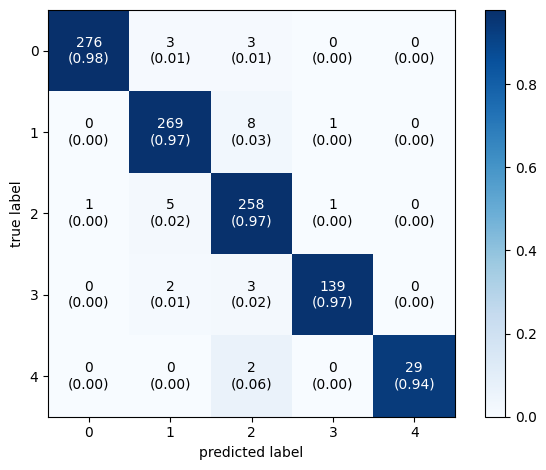

SNR: 5 dB


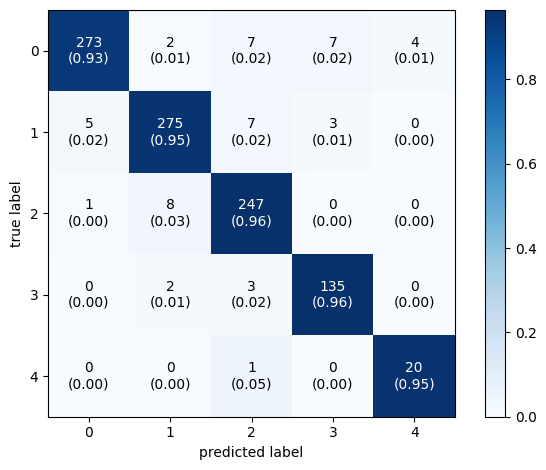

SNR: 0 dB


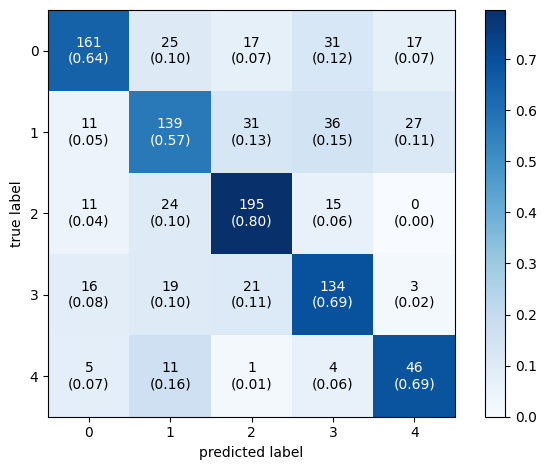

SNR: -5 dB


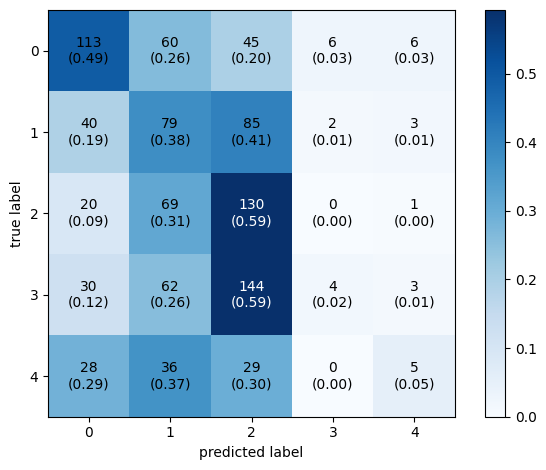

In [ ]:
for snr in [10, 5, 0, -5]:
    conf = {}
    conf['f_s'] = 10_000
    conf['SNR'] = snr
    conf['batch_size'] = 6
    conf['epochs'] = 10
    conf['learning_rate'] = 0.001

    print(f"SNR: {snr} dB")
    train(conf)